# NLP of Review Comments

### Importing libraries

In [31]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import time
import datetime

import os 

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# we use Python's langdetect 
from langdetect import detect

# import necessary libraries
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
from PIL import Image

import re
import string


In [110]:
root = r"C:\Users\aleen\Desktop\Reviews\amsterdam"

### Helper functions

In [107]:
def fill_nans(df,feature,filling="mean"):
    '''
    Fills Nans by replacing them with either median, mean, or a value chosen by the user.
    Default filling value is mean.
    '''
    if filling == "median":
        median = df[feature].median()
        df[feature] = df[feature].fillna(median)
    elif filling == "mean":
        mean = df[feature].mean()
        df[feature] = df[feature].fillna(mean)
    else:
        df[feature].fillna(filling, inplace=True)
        
def language_detection(text):
    try:
        return detect(text)
    except:
        return None
    
def plot_wordcloud(wordcloud, language):
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.title(language + ' Comments\n', fontsize=18, fontweight='bold')
    plt.show()
    
def print_sentiment_scores(sentence):
    snt = analyzer.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(snt)))
    
# getting only the negative score
def negative_score(text):
    negative_value = analyzer.polarity_scores(text)['neg']
    return negative_value

# getting only the neutral score
def neutral_score(text):
    neutral_value = analyzer.polarity_scores(text)['neu']
    return neutral_value

# getting only the positive score
def positive_score(text):
    positive_value = analyzer.polarity_scores(text)['pos']
    return positive_value

# getting only the compound score
def compound_score(text):
    compound_value = analyzer.polarity_scores(text)['compound']
    return compound_value

# removing stopwords, punctuations and normalizing the corpus
def clean(doc):
    stop_free = " ".join([word for word in doc.lower().split() if word not in stop])
    punc_free = "".join(token for token in stop_free if token not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

### Loading data

In [3]:
reviews = pd.read_csv(r"C:\Users\aleen\Desktop\Reviews\amsterdam\amsterdam_december_reviews.csv")
listings = pd.read_csv(r"C:\Users\aleen\Desktop\Reviews\amsterdam\amsterdam_listings.csv")

In [4]:
reviews.drop(["date","reviewer_id","reviewer_name"], axis=1,inplace=True)

In [6]:
print("The reviews dataset has {} rows and {} columns.".format(*reviews.shape))
print("It contains {} duplicates.".format(reviews.duplicated().sum()))

The reviews dataset has 493815 rows and 3 columns.
It contains 0 duplicates.


In [7]:
print("The listings dataset has {} rows and {} columns.".format(*listings.shape))
print("It contains {} duplicates.".format(listings.duplicated().sum()))

The listings dataset has 9962 rows and 79 columns.
It contains 0 duplicates.


### Creating a new dataset

In [8]:
# merging full df_1 + add only specific columns from df_2
df = pd.merge(reviews, listings[['id','number_of_reviews']], 
              left_on='listing_id', right_on='id', how='left')

In [9]:
print("The merged dataset has {} rows and {} columns.".format(*df.shape))
print("It contains {} duplicates.".format(df.duplicated().sum()))

The merged dataset has 493815 rows and 5 columns.
It contains 0 duplicates.


### A bit of cleaning

In [10]:
df.rename(columns = {'id_x':'id'}, inplace=True)

In [11]:
fill_nans(df,"number_of_reviews",0)

In [13]:
df.dropna(inplace=True)
df.drop(['id_y'], axis=1, inplace=True)

In [14]:
print("The dataset has {} rows and {} columns.".format(*df.shape))
print("It contains {} duplicates.".format(df.duplicated().sum()))

The dataset has 218454 rows and 4 columns.
It contains 0 duplicates.


In [126]:
print("We've again lost a lot of listings, due to dropping NaNs. The number is ", 9962-df.listing_id.nunique(), " out of 9962 originally.\nIn total, we now have ",df.listing_id.nunique()," listings left.")

We've again lost a lot of listings, due to dropping NaNs. The number is  1253  out of 9962 originally.
In total, we now have  8709  listings left.


### Language detection

In [19]:
%%time
df['language'] = df['comments'].apply(language_detection)

Wall time: 18min 4s


In [20]:
df.to_csv(r"C:\Users\aleen\Desktop\Reviews\amsterdam\amsterdam_listings_reviews.csv", index=False)
df = pd.read_csv(r"C:\Users\aleen\Desktop\Reviews\amsterdam\amsterdam_listings_reviews.csv")

In [21]:
df.head()

,listing_id,id,comments,number_of_reviews,language
0,27886,851027,"Excellent accommodation, close to everything, ...",206.0,en
1,27886,2359368,"What can I say, Flip provided the perfect Amst...",206.0,en
2,27886,3564846,"Ottima accoglienza, un soggiorno da ripetere. ...",206.0,it
3,27886,7509410,Just a superb way to spend time in Amsterdam. ...,206.0,en
4,27886,18429729,Perfect from start to finish! Flip went above ...,206.0,en


In [24]:
df.language.value_counts().head(10)

en       177187
fr        15814
de         8185
es         5543
nl         3122
it         2892
pt         1120
ru          864
ko          487
zh-cn       451
Name: language, dtype: int64

### Some dataviz 

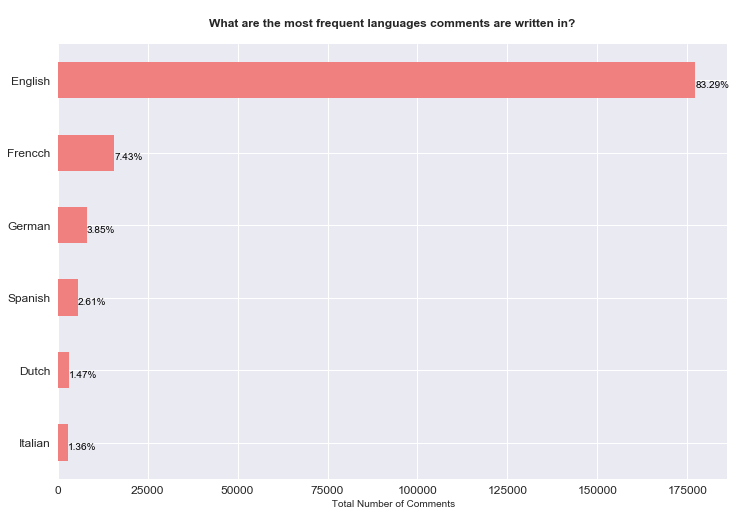

In [29]:
# visualizing the comments' languages b) neat and clean
ax = df.language.value_counts().head(6).plot(kind='barh', figsize=(12,8), color="lightcoral", 
                                             fontsize=12);

ax.set_title("\nWhat are the most frequent languages comments are written in?\n", 
             fontsize=12, fontweight='bold')
ax.set_xlabel(" Total Number of Comments", fontsize=10)
ax.set_yticklabels(['English', 'Frencch', 'German', 'Spanish', 'Dutch', 'Italian'])

# create a list to collect the plt.patches data
totals = []
# find the ind. values and append to list
for i in ax.patches:
    totals.append(i.get_width())
# get total
total = sum(totals)

# set individual bar labels using above list
for i in ax.patches:
    ax.text(x=i.get_width(), y=i.get_y()+.35, 
            s=str(round((i.get_width()/total)*100, 2))+'%', 
            fontsize=10, color='black')

# invert for largest on top 
ax.invert_yaxis()


In [30]:
# splitting the dataframes
df_eng = df[(df['language']=='en')]

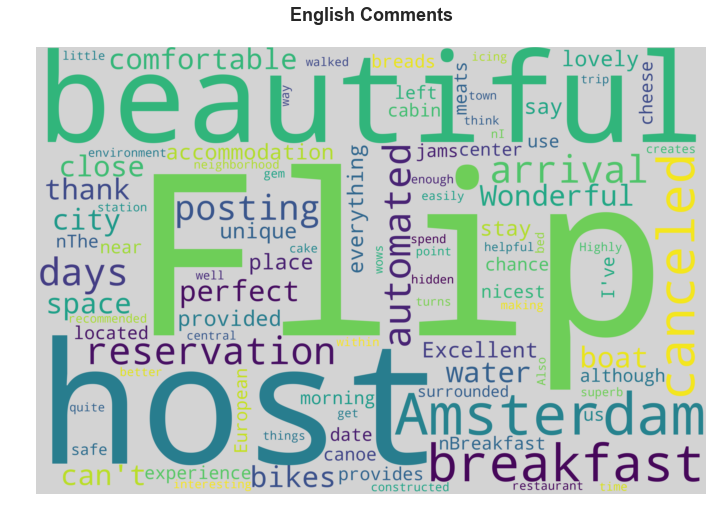

In [33]:
wordcloud = WordCloud(max_font_size=None, max_words=200, background_color="lightgrey", 
                      width=3000, height=2000,
                      stopwords=stopwords.words('english')).generate(str(df_eng.comments.values))

plot_wordcloud(wordcloud, 'English')

### Sentiment Analysis

In [35]:
analyzer = SentimentIntensityAnalyzer()

In [58]:
# splitting the dataframes
df_fr = df[(df['language']=='fr')]

In [59]:

df_fr['sentiment_compound'] = df_fr['comments'].apply(compound_score)

In [64]:
fr = list(df_fr.comments)
fr[1]

"Peniche hyper confort, chaleureuse, bien équipée ( et bien chauffée). Filip est attentif aux détails, et de petites attentions témoignent de son sens de l'accueil. Le quartier est tout proche du centre et de la gare. Avec les vélos mis à disposition c'est idéal. A conseiller!"

In [53]:
%%time

df_eng['sentiment_neg'] = df_eng['comments'].apply(negative_score)
df_eng['sentiment_neu'] = df_eng['comments'].apply(neutral_score)
df_eng['sentiment_pos'] = df_eng['comments'].apply(positive_score)
df_eng['sentiment_compound'] = df_eng['comments'].apply(compound_score)

Wall time: 7min 53s


In [56]:
df_eng.head()

,listing_id,id,comments,number_of_reviews,language,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_compound
0,27886,851027,"Excellent accommodation, close to everything, ...",206.0,en,0.000,0.440,0.560,0.9460
1,27886,2359368,"What can I say, Flip provided the perfect Amst...",206.0,en,0.033,0.707,0.260,0.9837
3,27886,7509410,Just a superb way to spend time in Amsterdam. ...,206.0,en,0.026,0.689,0.285,0.9736
4,27886,18429729,Perfect from start to finish! Flip went above ...,206.0,en,0.000,0.636,0.364,0.9422
5,27886,21170224,Why stay anywhere else in the city of canals w...,206.0,en,0.000,0.788,0.212,0.9062


In [78]:
df_eng.to_csv(r"C:\Users\aleen\Desktop\Reviews\amsterdam\amsterdam_listings_reviews_en.csv", index=False)
df = pd.read_csv(r"C:\Users\aleen\Desktop\Reviews\amsterdam\amsterdam_listings_reviews_en.csv")
df = df_eng

### Observation:
Vader only works in English, apparently.

In [66]:
print_sentiment_scores("Super comfortable, warm, well equipped (and well heated) barge. Filip is attentive to details, and small attentions testify to his sense of welcome. The area is very close to the center and the train station. With the bikes available it is ideal. To advice!")

Super comfortable, warm, well equipped (and well heated) barge. Filip is attentive to details, and small attentions testify to his sense of welcome. The area is very close to the center and the train station. With the bikes available it is ideal. To advice! {'neg': 0.0, 'neu': 0.649, 'pos': 0.351, 'compound': 0.9583}


In [75]:
print_sentiment_scores("Peniche hyper confort, chaleureuse, bien équipée ( et bien chauffée). Filip est attentif aux détails, et de petites attentions témoignent de son sens de l'accueil. Le quartier est tout proche du centre et de la gare. Avec les vélos mis à disposition c'est idéal. A conseiller!")

Peniche hyper confort, chaleureuse, bien équipée ( et bien chauffée). Filip est attentif aux détails, et de petites attentions témoignent de son sens de l'accueil. Le quartier est tout proche du centre et de la gare. Avec les vélos mis à disposition c'est idéal. A conseiller! {'neg': 0.041, 'neu': 0.959, 'pos': 0.0, 'compound': -0.2003}


### Translation

In [73]:
from googletrans import Translator
translator = Translator()

In [77]:
text = translator.translate('la pelicula es mala').text
analyzer.polarity_scores(text)

{'neg': 0.538, 'neu': 0.462, 'pos': 0.0, 'compound': -0.5423}

### Distribution of scores

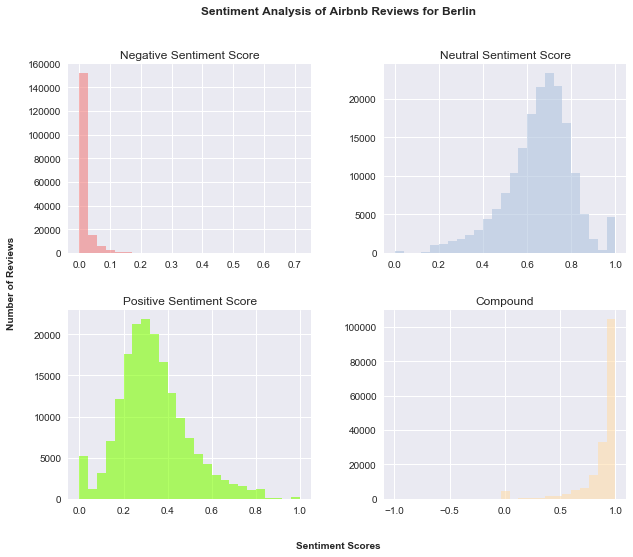

In [79]:
fig, axes = plt.subplots(2, 2, figsize=(10,8))

# plot all 4 histograms
df.hist('sentiment_neg', bins=25, ax=axes[0,0], color='lightcoral', alpha=0.6)
axes[0,0].set_title('Negative Sentiment Score')
df.hist('sentiment_neu', bins=25, ax=axes[0,1], color='lightsteelblue', alpha=0.6)
axes[0,1].set_title('Neutral Sentiment Score')
df.hist('sentiment_pos', bins=25, ax=axes[1,0], color='chartreuse', alpha=0.6)
axes[1,0].set_title('Positive Sentiment Score')
df.hist('sentiment_compound', bins=25, ax=axes[1,1], color='navajowhite', alpha=0.6)
axes[1,1].set_title('Compound')

# plot common x- and y-label
fig.text(0.5, 0.04, 'Sentiment Scores',  fontweight='bold', ha='center')
fig.text(0.04, 0.5, 'Number of Reviews', fontweight='bold', va='center', rotation='vertical')

# plot title
plt.suptitle('Sentiment Analysis of Airbnb Reviews for Berlin\n\n', fontsize=12, fontweight='bold');

In [81]:
# full dataframe with POSITIVE comments
df_pos = df.loc[df.sentiment_compound >= 0.95]

# only corpus of POSITIVE comments
pos_comments = df_pos['comments'].tolist()

# full dataframe with NEGATIVE comments
df_neg = df.loc[df.sentiment_compound < 0.0]

# only corpus of NEGATIVE comments
neg_comments = df_neg['comments'].tolist()

In [82]:
df_pos['text_length'] = df_pos['comments'].apply(len)
df_neg['text_length'] = df_neg['comments'].apply(len)

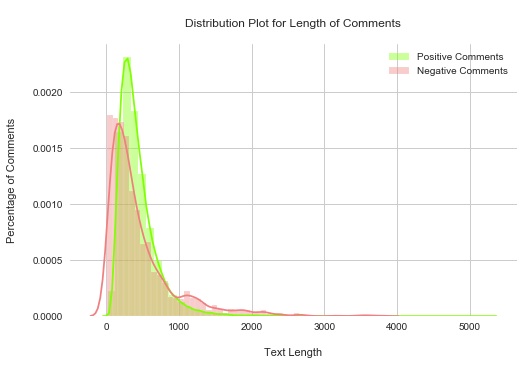

In [83]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))

sns.distplot(df_pos['text_length'], kde=True, bins=50, color='chartreuse')
sns.distplot(df_neg['text_length'], kde=True, bins=50, color='lightcoral')

plt.title('\nDistribution Plot for Length of Comments\n')
plt.legend(['Positive Comments', 'Negative Comments'])
plt.xlabel('\nText Length')
plt.ylabel('Percentage of Comments\n');

### Observation:
Apparently, Vader doesn't work all that well.

In [85]:
# read some negative comments
neg_comments[10:15]

['Georg was very attentious and the place was really well located, very close to the center but away from the city center confusion.',
 'Good place to stay visiting Amsterdam. Nice clean room with coffe pot that we used a lot. The stairs are steep. We just had backpacks so no problem but if you have limited mobility and a large suitcase it may be challenging. George was quick to answer any questions and we had no surprises. Would stay there again.',
 'Nice house in quiet neighbourhood. Bed is just a mattress on the floor but otherwise meets the needs. Be mindful of no A/C for summer. ',
 "Fabulous location - only 2km to the centre with plenty of restaurants, a shop opposite for food supplies, and very picturesque local scenery. We have been to Amsterdam many times but never knew this area was here as there are no hotels in this part of town. You can walk into the centre or take the no. 3 tram from round the corner or the no. 48 bus from up the road.\nThe room is on the first floor with

In [86]:
print_sentiment_scores(neg_comments[10])

Georg was very attentious and the place was really well located, very close to the center but away from the city center confusion. {'neg': 0.11, 'neu': 0.824, 'pos': 0.067, 'compound': -0.274}


In [103]:
print_sentiment_scores(neg_comments[18])

Couldn't have picked a better location. Shawna and family were very accommodating and the back room had everything you could need. Only shame that our travel plans did didn't allow for a longer stay. {'neg': 0.198, 'neu': 0.802, 'pos': 0.0, 'compound': -0.7329}


### Testing out a workaround

In [88]:
test = neg_comments[11]

In [89]:
test_list = test.split(".")

In [90]:
test_list

['Good place to stay visiting Amsterdam',
 ' Nice clean room with coffe pot that we used a lot',
 ' The stairs are steep',
 ' We just had backpacks so no problem but if you have limited mobility and a large suitcase it may be challenging',
 ' George was quick to answer any questions and we had no surprises',
 ' Would stay there again',
 '']

In [93]:
for t in test_list:
    print_sentiment_scores(t)
    print("\n")

Good place to stay visiting Amsterdam--- {'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'compound': 0.4404}


 Nice clean room with coffe pot that we used a lot {'neg': 0.0, 'neu': 0.593, 'pos': 0.407, 'compound': 0.6705}


 The stairs are steep------------------- {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


 We just had backpacks so no problem but if you have limited mobility and a large suitcase it may be challenging {'neg': 0.259, 'neu': 0.662, 'pos': 0.079, 'compound': -0.5223}


 George was quick to answer any questions and we had no surprises {'neg': 0.156, 'neu': 0.709, 'pos': 0.135, 'compound': -0.0772}


 Would stay there again----------------- {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


---------------------------------------- {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}




Average compound of splitted sentences would be 1.29, a positive score. 

In [96]:
test = neg_comments[13]
test_list = test.split(". ")
for t in test_list:
    print_sentiment_scores(t)
    print("\n")

Fabulous location - only 2km to the centre with plenty of restaurants, a shop opposite for food supplies, and very picturesque local scenery {'neg': 0.0, 'neu': 0.751, 'pos': 0.249, 'compound': 0.7425}


We have been to Amsterdam many times but never knew this area was here as there are no hotels in this part of town {'neg': 0.109, 'neu': 0.891, 'pos': 0.0, 'compound': -0.4215}


You can walk into the centre or take the no {'neg': 0.196, 'neu': 0.804, 'pos': 0.0, 'compound': -0.296}


3 tram from round the corner or the no-- {'neg': 0.239, 'neu': 0.761, 'pos': 0.0, 'compound': -0.296}


48 bus from up the road.
The room is on the first floor with very steep old-fashioned Dutch stairs but it's the first room you come to in the house so feels like having your own front door. {'neg': 0.0, 'neu': 0.91, 'pos': 0.09, 'compound': 0.5672}




Average compound score would be 1.63. Again, overall positive, as in the actual comment.

What about the actual negative comment?

In [98]:
test = neg_comments[14]
test_list = test.split(". ")
for t in test_list:
    print_sentiment_scores(t)
    print("\n")

This is the worst Airbnb experience I have ever had {'neg': 0.339, 'neu': 0.661, 'pos': 0.0, 'compound': -0.6249}


The place displayed on the pics is not the same we lived {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


The desk and the piano were hidden by the curtain {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


When u arrive there s a pile of clothes hanging on the wall at the corridor {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


It s listed in the session of entire home actually it s shared, private room, it s indicated in the description though which u often missed easily {'neg': 0.081, 'neu': 0.741, 'pos': 0.178, 'compound': 0.3818}


So what happened is when we are about to sleep the owner and her boyfriend arrived {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


What a surprise!  The bed is so not comfortable there s folding track in the middle it will definitely destroy ur back if your back is not that strong {'neg': 0.261, 'neu': 0.606, 'p

Average would be -0.16, so negative.

In [104]:
test = neg_comments[18]
test_list = test.split(". ")
for t in test_list:
    print_sentiment_scores(t)
    print("\n")

Couldn't have picked a better location-- {'neg': 0.376, 'neu': 0.624, 'pos': 0.0, 'compound': -0.3412}


Shawna and family were very accommodating and the back room had everything you could need {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


Only shame that our travel plans did didn't allow for a longer stay. {'neg': 0.323, 'neu': 0.677, 'pos': 0.0, 'compound': -0.5812}




Here, the average is still negative...
### Topic modelling

In [105]:
# importing libraries
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string

In [106]:
# prepare the preprocessing
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

In [108]:
doc_clean = [clean(comment).split() for comment in pos_comments]

In [113]:
from gensim import corpora
dictionary = corpora.Dictionary(doc_clean)
corpus = [dictionary.doc2bow(text) for text in doc_clean]

import pickle 
# uncomment the code if working locally
pickle.dump(corpus, open(root + '/corpus.pkl', 'wb'))
dictionary.save(root + '/dictionary.gensim')

In [115]:
import gensim

# let LDA find 3 topics
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=15)

# uncomment the code if working locally
#ldamodel.save('../input/sentimentData/model3.gensim')

topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.029*"boat" + 0.014*"houseboat" + 0.014*"day" + 0.013*"canal" + 0.013*"morning"')
(1, '0.061*"great" + 0.039*"stay" + 0.037*"place" + 0.036*"apartment" + 0.029*"recommend"')
(2, '0.111*"u" + 0.027*"apartment" + 0.019*"even" + 0.018*"gave" + 0.015*"left"')
(3, '0.033*"great" + 0.031*"apartment" + 0.026*"restaurant" + 0.019*"place" + 0.016*"amsterdam"')
(4, '0.028*"place" + 0.027*"stay" + 0.027*"amsterdam" + 0.024*"home" + 0.021*"host"')
(5, '0.018*"stair" + 0.012*"place" + 0.010*"one" + 0.010*"apartment" + 0.010*"floor"')
(6, '0.067*"minute" + 0.048*"walk" + 0.046*"station" + 0.044*"tram" + 0.028*"min"')
(7, '0.059*"cat" + 0.018*"dog" + 0.016*"van" + 0.015*"i’ve" + 0.014*"gogh"')
(8, '0.036*"bed" + 0.034*"room" + 0.028*"kitchen" + 0.022*"bathroom" + 0.017*"comfortable"')
(9, '0.034*"nice" + 0.032*"really" + 0.030*"place" + 0.022*"amsterdam" + 0.017*"u"')


### Feature engineering

In [116]:
df

,listing_id,id,comments,number_of_reviews,language,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_compound
0,27886,851027,"Excellent accommodation, close to everything, ...",206.0,en,0.000,0.440,0.560,0.9460
1,27886,2359368,"What can I say, Flip provided the perfect Amst...",206.0,en,0.033,0.707,0.260,0.9837
3,27886,7509410,Just a superb way to spend time in Amsterdam. ...,206.0,en,0.026,0.689,0.285,0.9736
4,27886,18429729,Perfect from start to finish! Flip went above ...,206.0,en,0.000,0.636,0.364,0.9422
5,27886,21170224,Why stay anywhere else in the city of canals w...,206.0,en,0.000,0.788,0.212,0.9062
7,27886,21700505,"The place was beautiful and bright, even when ...",206.0,en,0.000,0.719,0.281,0.9771
8,27886,21848508,Flip's houseboat is very cool. It is tastefull...,206.0,en,0.065,0.751,0.184,0.6309
11,27886,29052619,Host was marvellous! We are so happy we stayed...,206.0,en,0.000,0.622,0.378,0.9843
12,27886,30548926,Amazing place to stay. Flip was a great host a...,206.0,en,0.045,0.693,0.262,0.9259
13,27886,34691248,This was a great houseboat. Location is a bit ...,206.0,en,0.038,0.565,0.397,0.9862


In [123]:
listing_id = df.groupby(listing_id=27886)

TypeError: You have to supply one of 'by' and 'level'

In [124]:
listing_id.head()

,listing_id,id,comments,number_of_reviews,language,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_compound
0,27886,851027,"Excellent accommodation, close to everything, ...",206.0,en,0.000,0.440,0.560,0.9460
1,27886,2359368,"What can I say, Flip provided the perfect Amst...",206.0,en,0.033,0.707,0.260,0.9837
3,27886,7509410,Just a superb way to spend time in Amsterdam. ...,206.0,en,0.026,0.689,0.285,0.9736
4,27886,18429729,Perfect from start to finish! Flip went above ...,206.0,en,0.000,0.636,0.364,0.9422
5,27886,21170224,Why stay anywhere else in the city of canals w...,206.0,en,0.000,0.788,0.212,0.9062
206,31080,422962,Apartments are absolutely gorgeous. Quiet and ...,32.0,en,0.000,0.761,0.239,0.9537
207,31080,497118,A great apartment in a great location.\r\nMy f...,32.0,en,0.000,0.652,0.348,0.9844
209,31080,2062891,Beautiful and cozy apartment! It's comparable ...,32.0,en,0.000,0.785,0.215,0.9800
210,31080,4606745,"I booked for my brother and his friends, becau...",32.0,en,0.009,0.613,0.378,0.9921
211,31080,11336319,Excellent place to stay. Very clean and big! T...,32.0,en,0.000,0.722,0.278,0.9664


In [125]:
df.groupby('listing_id').mean()

,id,number_of_reviews,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_compound
listing_id,,,,,,
27886,2.083363e+08,206.0,0.013102,0.627874,0.359042,0.906574
31080,7.203901e+07,32.0,0.009269,0.686885,0.303885,0.932027
42970,9.870448e+07,463.0,0.010818,0.651843,0.337323,0.918277
43980,1.896715e+07,61.0,0.030733,0.707578,0.261689,0.843413
47061,7.934672e+07,182.0,0.012588,0.679558,0.307897,0.858374
49552,1.053750e+08,351.0,0.007666,0.664304,0.328034,0.932883
50515,1.242078e+08,15.0,0.000000,0.850700,0.149300,0.471650
50518,1.624141e+08,104.0,0.013156,0.631856,0.354978,0.862571
50523,2.277254e+08,279.0,0.010150,0.631165,0.358709,0.912701


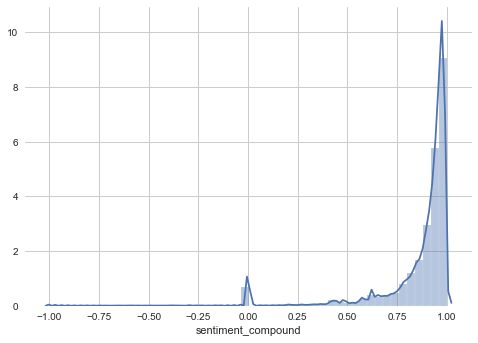

In [127]:
sns.distplot(df.sentiment_compound)